In [1]:
# !pip install ddgs

In [2]:
from __future__ import annotations

import os
import re
import json
import time
import math
import textwrap
import random
import logging
from dataclasses import dataclass, field
from datetime import datetime, timedelta, timezone
from typing import Any, Dict, List, Optional, Tuple

from dotenv import load_dotenv
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

# Agno (agents + tools)
from agno.agent import Agent
from agno.db.sqlite import SqliteDb
from agno.models.google import Gemini
from agno.tools import tool
from agno.tools.pandas import PandasTools
from agno.tools.duckduckgo import DuckDuckGoTools
from agno.memory import MemoryManager
from agno.tools.memory import MemoryTools

# ==== ENV ====
load_dotenv(".env")

# General
DEFAULT_RANGE          = "3M"
INCLUDE_LAST_48H       = True
ARTICLE_CAP            = 50
PER_SOURCE_CAP         = 15
CONCURRENCY            = 5
REQ_TIMEOUT            = 10
TICKER_TIME_BUDGET     = 180
LOG_MAX_CHARS          = 500
DDG_REGION             = "us-en"
DDG_SAFE               = "off"

# Technicals
SMA_WINDOWS            = (20, 50)
RSI_WINDOW             = 14

# Valuation
DCF_GROWTHS            = (0.03, 0.06, 0.09)
DCF_WACC               = 0.09
DCF_TERMINAL           = 0.02

# Evaluator
EVAL_THRESH            = 4.0
MAX_REFINE_PASSES      = 1

# Sources / Domains priority
ALLOWED_SOURCES        = [
    "reuters.com", "apnews.com", "cnbc.com", "sec.gov",
    "investor", "ir.", "press."
]

# DB files (separate per agent, as in your original files)
DB_EARNINGS            = "earnings_agent.db"
DB_EVALUATOR           = "evaluator_agent.db"
DB_INVESTMENT          = "investment_research_agent.db"
DB_MARKET              = "market_data_agent.db"
DB_MEMORY              = "memory_agent_memories.db"
DB_NEWS                = "news_agent.db"

# Models / Keys (from .env)
GEMINI_MODEL           = os.getenv("GEMINI_MODEL", "gemini-2.5-flash")
GEMINI_API_KEY         = os.getenv("GEMINI_API_KEY", "")
GOOGLE_API_KEY         = os.getenv("GOOGLE_API_KEY", "")

NEWSAPI_KEY            = os.getenv("NEWSAPI_KEY", None)
FRED_API_KEY           = os.getenv("FRED_API_KEY", None)

# Plot defaults (PDF-friendly)
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["font.size"] = 10
plt.rcParams["axes.grid"] = True

TARGETED_FIX_TIMEOUT_PER_ITEM = 8
TARGETED_FIX_MAX_ITEMS        = 3


### Logging Helpers (compact, PDF-friendly)

In [3]:
def truncate(s: str, n: int = LOG_MAX_CHARS) -> str:
    if s is None:
        return ""
    s = str(s)
    return (s[: n - 3] + "...") if len(s) > n else s

def log(tag: str, msg: str):
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    line = f"[{ts}] [{tag}] {msg}"
    print(truncate(line))

def pp_json(tag: str, obj: Any, max_chars: int = LOG_MAX_CHARS):
    try:
        text = json.dumps(obj, indent=2, ensure_ascii=False)
    except Exception:
        text = str(obj)
    log(tag, "\n" + truncate(text, max_chars))


### HTTP & HTML Utilities (fetch, clean, canonicalize, dedupe)

In [4]:
def http_get(url: str, timeout: int = REQ_TIMEOUT, headers: Optional[Dict[str, str]] = None) -> Optional[str]:
    try:
        if headers is None:
            headers = {"User-Agent": "Mozilla/5.0 (Notebook Financial Agent; +https://example.org)"}
        time.sleep(random.uniform(0.2, 0.6))
        r = requests.get(url, timeout=timeout, headers=headers)
        if r.status_code == 200:
            return r.text
    except Exception as e:
        log("HTTP", f"GET failed for {url}: {e}")
    return None

def canonicalize_url(url: str) -> str:
    if not url:
        return url
    # strip tracking parameters
    try:
        from urllib.parse import urlparse, urlunparse, parse_qsl, urlencode
        p = urlparse(url)
        qs = [(k, v) for (k, v) in parse_qsl(p.query, keep_blank_values=True) if not k.lower().startswith(("utm_", "ref"))]
        clean = urlunparse((p.scheme, p.netloc, p.path, p.params, urlencode(qs), ""))
        return clean
    except Exception:
        return url

def extract_domain(url: str) -> str:
    try:
        from urllib.parse import urlparse
        return urlparse(url).netloc.lower()
    except Exception:
        return ""

def clean_html_to_text(html: str) -> str:
    if not html:
        return ""
    try:
        soup = BeautifulSoup(html, "html.parser")
        # remove script/style
        for t in soup(["script", "style", "noscript"]):
            t.decompose()
        text = " ".join(soup.get_text(" ").split())
        return text
    except Exception:
        return ""

def dedupe_articles(arts: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    seen = set()
    out = []
    for a in arts:
        u = canonicalize_url(a.get("url", ""))
        t = (u.lower(), a.get("title", "").strip().lower())
        if t in seen:
            continue
        seen.add(t)
        a["url"] = u
        out.append(a)
    return out

def cap_per_source(arts: List[Dict[str, Any]], per_source_cap: int = PER_SOURCE_CAP) -> List[Dict[str, Any]]:
    counts: Dict[str, int] = {}
    out = []
    for a in arts:
        dom = extract_domain(a.get("url", ""))
        counts.setdefault(dom, 0)
        if counts[dom] < per_source_cap:
            out.append(a)
            counts[dom] += 1
    return out

def prioritize_allowed_sources(arts: List[Dict[str, Any]], allowed: List[str]) -> List[Dict[str, Any]]:
    def score(a):
        dom = extract_domain(a.get("url", ""))
        return 0 if any(tok in dom for tok in allowed) else 1
    return sorted(arts, key=score)


### Ticker & CIK Resolution (Yahoo suggest + SEC mapping)

In [5]:
_SEC_TICKER_MAP_CACHE: Optional[pd.DataFrame] = None

def yahoo_suggest(query: str, count: int = 5) -> List[Dict[str, Any]]:
    try:
        url = "https://query2.finance.yahoo.com/v1/finance/search"
        params = {"q": query, "quotesCount": count, "newsCount": 0, "listsCount": 0}
        r = requests.get(url, params=params, timeout=REQ_TIMEOUT)
        r.raise_for_status()
        data = r.json()
        out = []
        for q in data.get("quotes", []):
            out.append({
                "symbol": q.get("symbol"),
                "shortname": q.get("shortname"),
                "longname": q.get("longname"),
                "exchDisp": q.get("exchDisp"),
                "quoteType": q.get("quoteType"),
            })
        return out
    except Exception as e:
        log("SUGGEST", f"Yahoo suggest failed: {e}")
        return []

def resolve_tickers(inputs: List[str], max_results: int = 1) -> List[str]:
    syms: List[str] = []
    for raw in inputs:
        raw = (raw or "").strip()
        if not raw:
            continue
        if re.fullmatch(r"[A-Za-z\.\-]{1,6}", raw):
            syms.append(raw.upper())
            continue
        #resolve name → symbol via Yahoo suggest (pick top match)
        sugg = yahoo_suggest(raw, count=max_results)
        if sugg and sugg[0].get("symbol"):
            syms.append(sugg[0]["symbol"].upper())
        else:
            log("RESOLVE", f"No symbol found for '{raw}', skipping.")
    #dedupe, preserve order
    seen = set()
    out = []
    for s in syms:
        if s not in seen:
            out.append(s)
            seen.add(s)
    return out[:5]

def fetch_sec_ticker_mapping() -> pd.DataFrame:
    global _SEC_TICKER_MAP_CACHE
    if _SEC_TICKER_MAP_CACHE is not None:
        return _SEC_TICKER_MAP_CACHE
    try:
        url = "https://www.sec.gov/files/company_tickers.json"
        text = http_get(url, timeout=REQ_TIMEOUT, headers={"User-Agent":"Notebook Agent / SEC Map"})
        if text:
            j = json.loads(text)
            rows = []
            for _, v in j.items():
                rows.append({"cik": str(v.get("cik_str")).zfill(10), "ticker": v.get("ticker","").upper(), "title": v.get("title","")})
            df = pd.DataFrame(rows)
            _SEC_TICKER_MAP_CACHE = df
            return df
    except Exception as e:
        log("SEC", f"Mapping fetch failed: {e}")
    _SEC_TICKER_MAP_CACHE = pd.DataFrame(columns=["cik", "ticker", "title"])
    return _SEC_TICKER_MAP_CACHE

def ticker_to_cik(ticker: str) -> Optional[str]:
    df = fetch_sec_ticker_mapping()
    if df.empty:
        return None
    m = df[df["ticker"] == ticker.upper()]
    if m.empty:
        return None
    return str(m.iloc[0]["cik"]).zfill(10)


### Market Data & Technicals (yfinance, SMA/RSI, beta, chart)

In [6]:
def _normalize_period(p: str) -> str:
    if not p:
        return "3mo"
    p = p.strip().lower()
    mapping = {
        "1d": "1d", "5d": "5d",
        "1mo": "1mo", "3mo": "3mo", "6mo": "6mo",
        "1y": "1y", "2y": "2y", "5y": "5y", "10y": "10y",
        "ytd": "ytd", "max": "max",
        "1m": "1mo", "3m": "3mo", "6m": "6mo",
        "1y ": "1y", "ytd ": "ytd", "max ": "max"
    }
    if p in mapping:
        return mapping[p]
    if re.fullmatch(r"\d+m", p):
        return p.replace("m", "mo")
    if re.fullmatch(r"\d+M", p.upper()):
        return p[:-1] + "mo"
    return "3mo"


def fetch_prices(symbol: str, period: str = DEFAULT_RANGE, interval: str = "1d") -> pd.DataFrame:
    try:
        period = _normalize_period(period)
        df = yf.download(symbol, period=period, interval=interval, progress=False, auto_adjust=True)
        if isinstance(df, pd.DataFrame) and not df.empty:
            df = df.copy()
            df.reset_index(inplace=True)
            df.rename(columns={"Date":"date","Open":"open","High":"high","Low":"low","Close":"close","Volume":"volume"}, inplace=True)
            return df[["date","open","high","low","close","volume"]]
    except Exception as e:
        log("YF", f"download failed for {symbol}: {e}")
    return pd.DataFrame(columns=["date","open","high","low","close","volume"])

def compute_sma(series: pd.Series, window: int) -> pd.Series:
    return series.rolling(window=window, min_periods=max(2, window//2)).mean()

def compute_rsi(close: pd.Series, window: int = RSI_WINDOW) -> pd.Series:
    delta = close.diff()
    up = delta.clip(lower=0).rolling(window).mean()
    down = -delta.clip(upper=0).rolling(window).mean()
    rs = up / (down.replace(0, np.nan))
    rsi = 100 - (100 / (1 + rs))
    return rsi.bfill().ffill()

def compute_beta(symbol: str, df_price: pd.DataFrame, market_symbol: str = "^GSPC") -> Optional[float]:
    try:
        mkt = yf.download(market_symbol, period="6mo", interval="1d", progress=False, auto_adjust=True)
        if mkt.empty or df_price.empty:
            return None
        a = df_price.copy()
        a["date"] = pd.to_datetime(a["date"])
        a.set_index("date", inplace=True)
        a = a[["close"]].pct_change().dropna()

        b = mkt.copy()
        b.reset_index(inplace=True)
        b.rename(columns={"Date":"date","Close":"close"}, inplace=True)
        b["date"] = pd.to_datetime(b["date"])
        b.set_index("date", inplace=True)
        b = b[["close"]].pct_change().dropna()

        joined = a.join(b, how="inner", lsuffix="_stock", rsuffix="_mkt")
        if joined.empty:
            return None
        cov = np.cov(joined["close_stock"], joined["close_mkt"])[0][1]
        var = np.var(joined["close_mkt"])
        if var == 0:
            return None
        return float(cov / var)
    except Exception as e:
        log("BETA", f"Failed beta for {symbol}: {e}")
        return None

def plot_price_chart(symbol: str, df: pd.DataFrame) -> None:
    if df.empty:
        log("CHART", f"No data to plot for {symbol}")
        return
    x = pd.to_datetime(df["date"])
    c = df["close"].astype(float)
    v = df["volume"].astype(float)

    sma20 = compute_sma(c, SMA_WINDOWS[0])
    sma50 = compute_sma(c, SMA_WINDOWS[1])
    rsi = compute_rsi(c, RSI_WINDOW)

    fig, ax = plt.subplots()
    ax.plot(x, c, label=f"{symbol} Close")
    ax.plot(x, sma20, label=f"SMA{SMA_WINDOWS[0]}")
    ax.plot(x, sma50, label=f"SMA{SMA_WINDOWS[1]}")
    ax.set_title(f"{symbol} Price (with SMA)")
    ax.legend(loc="best")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()

    fig2, ax2 = plt.subplots()
    ax2.plot(x, rsi, label=f"RSI({RSI_WINDOW})")
    ax2.axhline(70, linestyle="--")
    ax2.axhline(30, linestyle="--")
    ax2.set_title(f"{symbol} RSI")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("RSI")
    plt.show()

def compute_overview_metrics(symbol: str, df: pd.DataFrame) -> Dict[str, Any]:
    out = {"symbol": symbol, "return_3m": None, "beta": None, "pe": None, "ev_ebitda": None, "next_earnings": None}
    try:
        if not df.empty and "close" in df:
            c = pd.to_numeric(df["close"], errors="coerce").dropna()
            if len(c) >= 2:
                out["return_3m"] = float((c.iat[-1] / c.iat[0]) - 1.0)

        if not df.empty and len(df) >= 30:
            out["beta"] = compute_beta(symbol, df)

        t = yf.Ticker(symbol)

        try:
            info = t.get_info()
            out["pe"] = info.get("trailingPE")
            out["ev_ebitda"] = info.get("enterpriseToEbitda")
        except Exception:
            try:
                fast = t.fast_info
                out["pe"] = getattr(fast, "trailing_pe", None) if hasattr(fast, "trailing_pe") else out["pe"]
            except Exception:
                pass

        try:
            ed = t.get_earnings_dates(limit=12)
            if isinstance(ed, pd.DataFrame) and not ed.empty:
                col = "Earnings Date" if "Earnings Date" in ed.columns else ed.columns[0]
                ed[col] = pd.to_datetime(ed[col])
                now = pd.Timestamp.utcnow()
                future = ed[ed[col] >= now]
                target = future.iloc[0][col] if not future.empty else ed.iloc[-1][col]
                out["next_earnings"] = str(target)
        except Exception:
            pass

    except Exception as e:
        log("OVERVIEW", f"Metrics failed for {symbol}: {e}")
    return out



### News Discovery & Cleaning (DDG via Agent; post-process helpers)

In [7]:
def filter_and_cap_articles(articles: List[Dict[str, Any]],
                            cap_total: int = ARTICLE_CAP,
                            per_source_cap: int = PER_SOURCE_CAP,
                            allowed: List[str] = ALLOWED_SOURCES) -> List[Dict[str, Any]]:
    arts = dedupe_articles(articles)
    def is_allowed(u: str) -> bool:
        dom = extract_domain(u)
        return any(tok in dom for tok in allowed)
    allowed_arts = [a for a in arts if is_allowed(a.get("url",""))]
    other_arts   = [a for a in arts if not is_allowed(a.get("url",""))]

    allowed_arts = cap_per_source(allowed_arts, per_source_cap)
    other_arts   = cap_per_source(other_arts, per_source_cap)

    out = allowed_arts[:cap_total]
    if len(out) < cap_total:
        out += other_arts[:(cap_total - len(out))]
    return out


### Agents (Investment, Earnings, Market+Tools, News, Evaluator, Memory [mandatory])

In [8]:
@tool(name="fetch_quote", description="Get latest stock price and metadata for a symbol.")
def fetch_quote(symbol: str) -> str:
    try:
        ticker = yf.Ticker(symbol)
        price = None
        try:
            info = ticker.fast_info
            price = getattr(info, "last_price", None)
        except Exception:
            pass
        if price is None:
            hist = ticker.history(period="5d", interval="1d", auto_adjust=True)
            if not hist.empty:
                price = float(hist["Close"].iloc[-1])
        result = {
            "symbol": symbol,
            "last_price": price,
        }
        return json.dumps(result)
    except Exception as e:
        return json.dumps({"symbol": symbol, "error": str(e)})

@tool(name="fetch_ohlcv", description="Get last 5 OHLCV rows for a symbol.")
def fetch_ohlcv(symbol: str, period: str = "1y", interval: str = "1d") -> str:
    try:
        df = yf.download(symbol, period=period, interval=interval, progress=False, auto_adjust=True)
        if df.empty:
            return json.dumps({"symbol": symbol, "rows": 0, "ohlcv": []})
        tail = df.tail(5).reset_index()
        tail["Date"] = tail["Date"].astype(str)
        result = {
            "symbol": symbol,
            "rows": len(df),
            "period": period,
            "interval": interval,
            "tail5": tail.to_dict(orient="records"),
        }
        return json.dumps(result)
    except Exception as e:
        return json.dumps({"symbol": symbol, "error": str(e)})

MARKET_TOOLS = [fetch_quote, fetch_ohlcv]

market_data_agent = Agent(
    name="Market Data Agent",
    model=Gemini(id=GEMINI_MODEL),
    instructions=[
        "You are a financial market data agent.",
        "When the user provides a stock symbol or company name, call fetch_quote or fetch_ohlcv "
        "to fetch and summarize market data.",
        "Be clear about symbol, time range, and assumptions."
    ],
    tools=MARKET_TOOLS,
    db=SqliteDb(db_file=DB_MARKET),
    add_datetime_to_context=True,
    markdown=True,
)

# ========== Earnings Agent ==========
earnings_agent = Agent(
    name="Earnings Agent",
    model=Gemini(id=GEMINI_MODEL),
    instructions=[
        "You are an earnings analysis agent for financial analysis.",
        "The user will provide a company name or stock symbol. Retrieve and summarize key insights from financial filings and earnings reports (such as SEC EDGAR) for the provided company or symbol.",
        "Focus on analyzing:",
        "1. Revenue and earnings growth trends",
        "2. Key financial ratios (P/E, debt-to-equity, ROE, etc.)",
        "3. Cash flow analysis and liquidity position",
        "4. Segment performance and business unit analysis",
        "5. Management guidance and forward-looking statements",
        "6. Risk factors and regulatory compliance issues",
        "7. Recent acquisitions, divestitures, or strategic initiatives",
        "Present your findings in a structured format with clear insights and implications for investment decisions.",
        "Highlight both positive and negative trends with supporting data from the filings.",
    ],
    db=SqliteDb(db_file=DB_EARNINGS),
    add_datetime_to_context=True,
    markdown=True,
)

# ========== Investment Research Agent ==========
investment_research_agent = Agent(
    name="Investment Research Agent",
    model=Gemini(id=GEMINI_MODEL),
    instructions=[
        "You are an investment research agent for financial analysis.",
        "The user will provide a stock symbol or company name. Plan a research workflow for the provided stock symbol, including which data to gather, which agents to consult, and how to synthesize the findings.",
        "Create a comprehensive research plan that includes:",
        "1. Market data analysis (price trends, volume, technical indicators)",
        "2. News sentiment analysis (recent news articles and their impact)",
        "3. Earnings and financial filings review (SEC filings, quarterly reports)",
        "4. Risk assessment and market positioning",
        "5. Investment recommendation framework",
        "Structure your response as a detailed research workflow with specific steps and data sources.",
        "Provide actionable insights and recommendations based on your analysis framework.",
    ],
    db=SqliteDb(db_file=DB_INVESTMENT),
    add_datetime_to_context=True,
    markdown=True,
)

# ========== News Agent (DDG + pandas tools; cap 50; per-source cap 15; dedupe; skip paywalls) ==========
news_agent = Agent(
    name="News Agent",
    model=Gemini(id=GEMINI_MODEL),
    instructions=[
        "You are a financial analysis assistant. The user will provide the name of a company or its stock ticker symbol.",
        "Search recent and historical news (DuckDuckGoTools) for the provided company/ticker, bounded by time when specified.",
        f"Return up to {ARTICLE_CAP} articles in total, and cap at {PER_SOURCE_CAP} per source domain.",
        "Prioritize recognized outlets (Reuters, AP, CNBC), SEC, and company IR/PR, then include others if needed.",
        "Skip paywalled or blocked pages. Dedupe by canonical URL and near-duplicate titles.",
        "Then analyze each retained article and classify them as Positive / Negative / Neutral for stock impact.",
        "Create a pandas DataFrame with columns: Title | Source | URL | Date | Sentiment | Summary",
        "Respond with a concise bullet list reflecting the DataFrame contents (do NOT dump the entire table verbatim).",
        "Keep the output compact to fit in a PDF; keep each bullet under 2 lines when possible."
    ],
    db=SqliteDb(db_file=DB_NEWS),
    tools=[DuckDuckGoTools(fixed_max_results=ARTICLE_CAP), PandasTools()],
    tool_call_limit=20,
    add_history_to_context=True,
    add_datetime_to_context=True,
    markdown=True,
)

# ========== Evaluator Agent (JSON rubric; one refine pass wired to Investment Agent) ==========
evaluator_agent = Agent(
    name="Evaluator Agent",
    model=Gemini(id=GEMINI_MODEL),
    instructions=[
        "You are an evaluation agent for financial research outputs.",
        "Evaluate drafts for completeness, accuracy, and clarity.",
        "Provide actionable feedback with specific, constructive suggestions.",
        "If data is missing or uncertain, recommend concrete next steps to resolve gaps.",
        "Always return a JSON object with this schema:",
        "{"
        '  "scores": {"factuality": float, "coverage": float, "relevance": float, "actionability": float, "overall": float},'
        '  "feedback": {"strengths": [str], "gaps": [str], "suggestions": [str]},'
        '  "actions": {"priority_fixes": [str], "checks": [str], "followups": [str]},'
        '  "ready_for_delivery": bool'
        "}",
        "Scores must be 0.0–5.0. The 'overall' is the mean of the four dimensions.",
        f"Mark 'ready_for_delivery' true only if overall ≥ {EVAL_THRESH}.",
        "Be objective, concise, and specific. Keep JSON compact."
    ],
    db=SqliteDb(db_file=DB_EVALUATOR),
    add_datetime_to_context=True,
    markdown=True,
)

def optimize_with_investment_agent(draft: str, revision_plan_json: Dict[str, Any], snapshot_readonly: Optional[str] = None) -> str:
    guard = (
        "\n\n== Snapshot (READ-ONLY) ==\n"
        f"{snapshot_readonly}\n\n"
        "RULES:\n"
        "1) Do NOT fabricate or alter any numbers in the Snapshot section.\n"
        "2) If a value is missing there, leave it as 'n/a'.\n"
        "3) Only revise prose sections (news bullets, valuation commentary, risks/catalysts).\n"
    ) if snapshot_readonly else ""
    prompt = (
        "You are revising an investment research brief based on a JSON revision plan.\n"
        "Apply only the concrete edits that improve factuality, coverage, relevance, and actionability.\n"
        "Keep the brief compact and PDF-friendly.\n\n"
        "== Current Draft ==\n"
        f"{draft}\n\n"
        "== Revision Plan (JSON) ==\n"
        f"{json.dumps(revision_plan_json, ensure_ascii=False)}"
        f"{guard}\n"
        "Return only the revised brief."
    )
    resp = investment_research_agent.run(prompt)
    return getattr(resp, "content", str(resp))


# ========== Memory Agent (MANDATORY) ==========
memory_agent = Agent(
    name="Memory Agent",
    model=Gemini(id=GEMINI_MODEL),
    session_id="financial_memory_session",
    user_id="financial_user",
    instructions=[
        "You are a memory agent that stores and retrieves information for financial analysis.",
        "User may provide new information related to financial analysis. Store this information in a structured format.",
        "Always acknowledge if any information is stored.",
        "When asked about a specific company/ticker, retrieve and summarize relevant stored memories."
    ],
    tools=[
        MemoryTools(
            db=SqliteDb(db_file=DB_MEMORY),
        )
    ],
    memory_manager=MemoryManager(
        memory_capture_instructions=[
            "Capture any memory that can be used for financial analysis (news, performance, trends, opinions).",
            "Add relevant topics/tags (company, ticker, date, sentiment).",
            "Store multiple items as separate memories when appropriate."
        ],
        system_message="Use Think/Get/Add/Update/Delete/Analyze tools to manage memories. Do not reveal internal chain-of-thought."
    ),
    add_datetime_to_context=True,
    markdown=True,
)


### Prompt-Chaining Helpers (Ingest → Preprocess → Classify → Extract → Summarize)

In [9]:
def prompt_chain_news(ticker_or_name: str, date_range: str = DEFAULT_RANGE) -> str:
    """
    Wrapper that instructs the News Agent to explicitly follow:
    Ingest → Preprocess → Classify → Extract → Summarize
    Returns a compact, bullet-style summary suitable for PDF logs.
    """
    prompt = (
        f"Find and analyze recent/historical news for '{ticker_or_name}' within {date_range}. "
        f"Guarantee inclusion of the last 48 hours. "
        f"Follow the workflow strictly: Ingest -> Preprocess -> Classify -> Extract -> Summarize. "
        f"Respect caps: total {ARTICLE_CAP}, ≤{PER_SOURCE_CAP} per domain, prioritize allowed sources, skip paywalls, dedupe."
    )
    log("CHAIN", f"News prompt-chaining for {ticker_or_name}")
    resp = news_agent.run(prompt)
    content = getattr(resp, "content", str(resp))
    return truncate(content)


### Routing (explicit + intelligent; standardized return)

In [10]:
AGENT_REGISTRY = {
    "investment": investment_research_agent,
    "earnings": earnings_agent,
    "news": news_agent,
    "memory": memory_agent,
    "market": market_data_agent,
    "evaluator": evaluator_agent,
}

ROUTING_MAP = {
    "earnings": "earnings",
    "financial": "earnings",
    "filings": "earnings",
    "sec": "earnings",
    "quarterly": "earnings",
    "annual": "earnings",

    "news": "news",
    "sentiment": "news",
    "articles": "news",
    "headlines": "news",

    "market": "market",
    "price": "market",
    "stock": "market",
    "quote": "market",
    "ohlcv": "market",
    "technical": "market",

    "memory": "memory",
    "remember": "memory",
    "recall": "memory",
    "store": "memory",

    "investment": "investment",
    "research": "investment",
    "analysis": "investment",
    "recommendation": "investment",
    "general": "investment",

    "evaluator": "evaluator",
    "evaluate": "evaluator",
    "quality": "evaluator",
    "assess": "evaluator",
}

def route_content(content_type: str, data: str, **kwargs) -> Dict[str, Any]:
    key = ROUTING_MAP.get(content_type.lower().strip())
    if not key:
        return {"agent": None, "status": "error", "text": f"Unknown content type '{content_type}'", "meta": {}}
    agent = AGENT_REGISTRY.get(key)
    if not agent:
        return {"agent": None, "status": "error", "text": f"Agent '{key}' not found", "meta": {}}
    try:
        resp = agent.run(data, **kwargs)
        text = getattr(resp, "content", str(resp))
        return {"agent": agent.name, "status": "success", "text": text, "meta": {"type": content_type}}
    except Exception as e:
        return {"agent": agent.name, "status": "error", "text": str(e), "meta": {"type": content_type}}

def intelligent_routing(content: str, context: Optional[str] = None) -> Dict[str, Any]:
    content_lower = (content or "").lower()
    ctx = (context or "").lower()
    combined = f"{content_lower} {ctx}"

    weights = {
        "market": 0.0,
        "earnings": 0.0,
        "news": 0.0,
        "memory": 0.0,
        "evaluator": 0.0,
    }
    def hit(words, cat):
        for w in words:
            if w in combined:
                weights[cat] += 1.0

    hit(["price", "stock", "quote", "ohlcv", "volume", "technical", "chart", "ticker"], "market")
    hit(["earnings", "financial", "filings", "sec", "quarterly", "annual", "revenue", "10-k", "10-q", "8-k"], "earnings")
    hit(["news", "article", "headlines", "sentiment", "press release"], "news")
    hit(["remember", "recall", "store", "forget", "memory", "retrieve"], "memory")
    hit(["evaluate", "assess", "quality", "feedback", "score"], "evaluator")

    if re.search(r"\b[A-Z]{1,5}\b", content):
        weights["market"] += 2.0

    content_type = max(weights.items(), key=lambda x: x[1])[0]
    confidence = min(weights[content_type] / 5.0, 1.0) if weights[content_type] > 0 else 0.5

    res = route_content(content_type, content)
    res["detected_type"] = content_type
    res["confidence"] = round(confidence, 2)
    res["routing_method"] = "intelligent"
    return res


### Valuation (Multiples + DCF-lite)

In [11]:
def valuation_multiples(symbol: str, last_price: Optional[float] = None) -> Dict[str, Any]:
    """
    Best-effort multiples target:
    - Try sector median P/E via yfinance info (may not always be present)
    - Fallback to company's own trailing P/E
    - If EPS/PE unavailable, return None gracefully
    """
    t = yf.Ticker(symbol)
    result = {"method":"multiples", "target": None, "implied_move": None, "inputs": {}}
    try:
        info = {}
        try:
            info = t.get_info()
        except Exception:
            pass

        trailing_pe = info.get("trailingPE")
        forward_eps = info.get("forwardEps")
        sector_pe = info.get("trailingPE")

        if last_price is None:
            try:
                fast = t.fast_info
                last_price = getattr(fast, "last_price", None)
            except Exception:
                pass

        if sector_pe is None and trailing_pe:
            sector_pe = trailing_pe * 0.95

        if forward_eps and sector_pe:
            target = float(sector_pe) * float(forward_eps)
        elif trailing_pe and forward_eps:
            target = float(trailing_pe) * float(forward_eps)
        else:
            return result

        result["target"] = float(target)
        if last_price:
            result["implied_move"] = float(target / last_price - 1.0)
        result["inputs"] = {"trailingPE": trailing_pe, "forwardEps": forward_eps, "sectorPE": sector_pe, "last_price": last_price}
        return result
    except Exception as e:
        log("VAL", f"Multiples failed for {symbol}: {e}")
        return result

def valuation_dcf_lite(symbol: str, last_price: Optional[float] = None,
                       growths: Tuple[float,float,float] = DCF_GROWTHS,
                       wacc: float = DCF_WACC, terminal: float = DCF_TERMINAL) -> Dict[str, Any]:
    """
    Simple DCF using last FY/TTM FCF as starting point. If FCF unavailable or negative, return None gracefully.
    """
    t = yf.Ticker(symbol)
    res = {"method":"dcf-lite", "low": None, "base": None, "high": None, "implied_move": None, "inputs": {}}
    try:
        fcf = None
        try:
            cf = t.get_cashflow()
            if isinstance(cf, pd.DataFrame) and not cf.empty:
                for label in ["Free Cash Flow", "FreeCashFlow", "FreeCashFlow"]:
                    if label in cf.index:
                        series = cf.loc[label]
                        if not series.empty:
                            fcf = float(series.iloc[0])
                            break
        except Exception:
            pass

        if fcf is None or fcf <= 0:
            return res

        if last_price is None:
            try:
                fast = t.fast_info
                last_price = getattr(fast, "last_price", None)
            except Exception:
                pass

        shares = None
        try:
            info = t.get_info()
            market_cap = info.get("marketCap")
            if market_cap and last_price and last_price > 0:
                shares = float(market_cap) / float(last_price)
        except Exception:
            pass

        if not shares:
            return res

        def price_from_fcf(g: float) -> float:
            #5y 2-stage growth then terminal
            horizon = 5
            disc = 1.0
            pv = 0.0
            curr = float(fcf)
            for year in range(1, horizon + 1):
                curr = curr * (1.0 + g)
                disc *= (1.0 + wacc)
                pv += curr / disc
            #terminal using last year's cash flow
            terminal_cf = curr * (1.0 + terminal)
            terminal_val = terminal_cf / (wacc - terminal) if wacc > terminal else 0.0
            pv += terminal_val / disc
            #per-share
            return pv / shares

        low_p  = price_from_fcf(growths[0])
        base_p = price_from_fcf(growths[1])
        high_p = price_from_fcf(growths[2])

        res["low"], res["base"], res["high"] = float(low_p), float(base_p), float(high_p)
        if last_price:
            res["implied_move"] = float(base_p / last_price - 1.0)
        res["inputs"] = {"fcf": fcf, "shares": shares, "wacc": wacc, "terminal": terminal, "growths": growths, "last_price": last_price}
        return res
    except Exception as e:
        log("VAL", f"DCF-lite failed for {symbol}: {e}")
        return res


### Backtesting (ER event study; sentiment vs next-day return)

In [12]:
def get_earnings_dates(symbol: str, limit: int = 8) -> pd.DataFrame:
    try:
        t = yf.Ticker(symbol)
        df = t.get_earnings_dates(limit=limit)
        if isinstance(df, pd.DataFrame) and not df.empty:
            df = df.copy()
            if "Earnings Date" in df.columns:
                df["EarningsDate"] = pd.to_datetime(df["Earnings Date"])
            elif df.index.name and "date" in df.index.name.lower():
                df["EarningsDate"] = pd.to_datetime(df.index)
            else:
                first_col = df.columns[0]
                df["EarningsDate"] = pd.to_datetime(df[first_col], errors="coerce")
            df = df.dropna(subset=["EarningsDate"])
            return df
    except Exception as e:
        log("ER", f"Earnings dates failed for {symbol}: {e}")
    return pd.DataFrame(columns=["EarningsDate"])


def event_study(symbol: str, window: int = 5) -> Dict[str, Any]:
    ed = get_earnings_dates(symbol, limit=8)
    if ed.empty:
        return {"rows": 0, "drifts": []}
    px = yf.download(symbol, period="1y", interval="1d", progress=False, auto_adjust=True)
    if px.empty:
        return {"rows": 0, "drifts": []}
    px.reset_index(inplace=True)
    px["Date"] = pd.to_datetime(px["Date"])
    px.set_index("Date", inplace=True)
    drifts = []
    for _, row in ed.iterrows():
        d = row["EarningsDate"].normalize()
        try:
            if d not in px.index:
                for off in range(1, 4):
                    if d + pd.Timedelta(days=off) in px.index:
                        d = d + pd.Timedelta(days=off)
                        break
                    if d - pd.Timedelta(days=off) in px.index:
                        d = d - pd.Timedelta(days=off)
                        break
            if d not in px.index:
                continue
            win = px.loc[d - pd.Timedelta(days=window*2): d + pd.Timedelta(days=window*2)].copy()
            win = win.asfreq("D").ffill()
            anchor = win.loc[d]["Close"]
            before = win.loc[d - pd.Timedelta(days=window)]["Close"] if (d - pd.Timedelta(days=window)) in win.index else None
            after  = win.loc[d + pd.Timedelta(days=window)]["Close"] if (d + pd.Timedelta(days=window)) in win.index else None
            if before and after:
                drift = float(after / before - 1.0)
                drifts.append({"date": str(d.date()), "drift_T-5_to_T+5": drift})
        except Exception:
            continue
    return {"rows": len(drifts), "drifts": drifts}

def sentiment_to_numeric(sent: str) -> int:
    s = (sent or "").lower()
    if "pos" in s:
        return 1
    if "neg" in s:
        return -1
    return 0

def sentiment_correlation(next_day: pd.Series, sentiments: pd.Series) -> Dict[str, Any]:
    try:
        df = pd.DataFrame({"ret": next_day, "sent": sentiments}).dropna()
        if len(df) < 5:
            return {"count": len(df), "corr": None, "accuracy": None}
        corr = float(df["ret"].corr(df["sent"]))
        # naive sign accuracy
        pred = np.sign(df["sent"])
        truth = np.sign(df["ret"])
        acc = float((pred == truth).mean())
        return {"count": len(df), "corr": corr, "accuracy": acc}
    except Exception as e:
        log("BT", f"Sentiment correlation failed: {e}")
        return {"count": 0, "corr": None, "accuracy": None}


### Evaluator→Optimizer (one pass)

In [13]:

def _detect_data_gaps(eval_json: Dict[str, Any]) -> Dict[str, bool]:
    """
    Parse evaluator feedback JSON and infer which *data* is missing/weak.
    We keep it heuristic + tiny to stay robust.
    """
    txt = json.dumps(eval_json, ensure_ascii=False).lower()
    need = {
        "need_48h_news": any(k in txt for k in ["48h", "last 48h", "recent news", "latest news", "today", "yesterday"]),
        "need_next_er": any(k in txt for k in ["next earnings", "earnings date", "earnings schedule", "er date"]),
        "need_valuation": any(k in txt for k in ["valuation", "price target", "dcf", "multiples", "pe", "ev/ebitda"]),
    }
    return need

def _last_price_from_prices(dfp: pd.DataFrame) -> Optional[float]:
    try:
        if not dfp.empty:
            return float(dfp["close"].astype(float).iat[-1])
    except Exception:
        pass
    return None

def _refresh_48h_news(symbol: str) -> str:
    #Force a narrowly worded prompt to emphasize the last 48 hours.
    prompt = (
        f"Find and analyze the most impactful news for '{symbol}' from the last 48 hours ONLY. "
        f"Follow: Ingest -> Preprocess -> Classify -> Extract -> Summarize. "
        f"Cap total {ARTICLE_CAP}, ≤{PER_SOURCE_CAP}/domain, prioritize allowed sources, dedupe, skip paywalls. "
        f"Return compact bullets suitable for PDF."
    )
    log("FIX", f"{symbol}: refreshing 48h news")
    resp = news_agent.run(prompt)
    return truncate(getattr(resp, "content", str(resp)))

def _refresh_next_earnings(symbol: str, df_prices: pd.DataFrame) -> Dict[str, Any]:
    #Recompute overview (which includes next ER if available)
    log("FIX", f"{symbol}: fetching next earnings date")
    return compute_overview_metrics(symbol, df_prices)

def _refresh_valuation(symbol: str, df_prices: pd.DataFrame) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    log("FIX", f"{symbol}: recomputing valuation (multiples + DCF-lite)")
    last_price = _last_price_from_prices(df_prices)
    mul = valuation_multiples(symbol, last_price=last_price)
    dcf = valuation_dcf_lite(symbol, last_price=last_price)
    return mul, dcf

def apply_targeted_fixes_if_any(
    symbol: str,
    eval_json: Dict[str, Any],
    pieces: Dict[str, Any],
    time_budget_left: float
) -> Dict[str, Any]:
    """
    Runs up to TARGETED_FIX_MAX_ITEMS quick, *data* fixes before the rewrite:
      - 48h news
      - next earnings date
      - valuation
    Keeps logs compact; respects per-item timeout conceptually (we already use light calls).
    """
    start = time.time()
    needs = _detect_data_gaps(eval_json)
    fixes_done = 0

    #48h news
    if needs.get("need_48h_news") and fixes_done < TARGETED_FIX_MAX_ITEMS:
        pieces["news_txt"] = _refresh_48h_news(symbol)
        fixes_done += 1

    #next earnings date (overview recompute)
    if needs.get("need_next_er") and fixes_done < TARGETED_FIX_MAX_ITEMS:
        pieces["overview"] = _refresh_next_earnings(symbol, pieces["df_prices"])
        fixes_done += 1

    #valuation recompute
    if needs.get("need_valuation") and fixes_done < TARGETED_FIX_MAX_ITEMS:
        mul, dcf = _refresh_valuation(symbol, pieces["df_prices"])
        pieces["mul"], pieces["dcf"] = mul, dcf
        fixes_done += 1

    elapsed = time.time() - start
    log("FIX", f"{symbol}: targeted fixes done={fixes_done} in {elapsed:.1f}s (budget left ~{max(0.0, time_budget_left - elapsed):.1f}s)")
    return pieces


In [14]:
def evaluate_brief(text: str) -> Dict[str, Any]:
    prompt = (
        "Evaluate the following research brief. Return ONLY the JSON with keys: "
        '{"scores":{"factuality":float,"coverage":float,"relevance":float,"actionability":float,"overall":float},'
        '"feedback":{"strengths":[str],"gaps":[str],"suggestions":[str]},'
        '"actions":{"priority_fixes":[str],"checks":[str],"followups":[str]},'
        '"ready_for_delivery":bool}'
        "}\n\n== BRIEF ==\n" + text
    )
    resp = evaluator_agent.run(prompt)
    try:
        data = json.loads(getattr(resp, "content", str(resp)))
    except Exception:
        data = {"raw_response": getattr(resp, "content", str(resp))}
    # ensure overall
    try:
        sc = data.get("scores", {})
        if "overall" not in sc and sc:
            vals = [float(sc.get(k, 0.0)) for k in ["factuality","coverage","relevance","actionability"]]
            data["scores"]["overall"] = float(sum(vals) / max(1, len(vals)))
    except Exception:
        pass
    return data


def refine_once_if_needed(
    symbol: str,
    draft: str,
    eval_json: Dict[str, Any],
    pieces: Dict[str, Any],
    thresh: float = EVAL_THRESH,
    ticker_time_budget_left: float = TICKER_TIME_BUDGET
) -> Tuple[str, Dict[str, Any]]:
    """
    Single refine pass:
      1) If below threshold → run quick targeted *data* fixes (48h news / next ER / valuation) if evaluator hints.
      2) Rebuild draft from updated pieces.
      3) Rewrite once with Investment Research Agent (optimize_with_investment_agent) while freezing Snapshot numerics.
      4) Re-evaluate and return.
    """
    try:
        overall = float(eval_json.get("scores", {}).get("overall", 0.0))
    except Exception:
        overall = 0.0
    if overall >= thresh:
        return draft, eval_json

    pieces = apply_targeted_fixes_if_any(symbol, eval_json, pieces, ticker_time_budget_left)

    updated_draft = brief_sections_to_text(
        symbol,
        pieces["overview"],
        pieces["news_txt"],
        pieces["mul"],
        pieces["dcf"],
        pieces["evstudy"],
        eval_json={}
    )

    ov = pieces.get("overview", {}) or {}
    snap_lines = []
    #3M Return
    try:
        snap_lines.append(f"- 3M Return: {float(ov.get('return_3m')):.2%}")
    except Exception:
        snap_lines.append("- 3M Return: n/a")
    #Beta
    try:
        snap_lines.append(f"- Beta (vs ^GSPC): {float(ov.get('beta')):.2f}")
    except Exception:
        snap_lines.append("- Beta: n/a")
    #P/E
    try:
        snap_lines.append(f"- P/E: {float(ov.get('pe')):.2f}")
    except Exception:
        snap_lines.append("- P/E: n/a")
    #EV/EBITDA
    try:
        snap_lines.append(f"- EV/EBITDA: {float(ov.get('ev_ebitda')):.2f}")
    except Exception:
        snap_lines.append("- EV/EBITDA: n/a")
    #Next earnings
    ne = ov.get("next_earnings") or "n/a"
    snap_lines.append(f"- Next Earnings: {ne}")
    snapshot_readonly = "\n".join(snap_lines)

    #One rewrite using the Investment Research Agent (Snapshot is frozen/read-only)
    improved = optimize_with_investment_agent(
        updated_draft,
        {
            "objective": f"Raise overall score to ≥ {thresh} while keeping brief compact and factual.",
            "edits": [{
                "type": "revise",
                "target": "brief",
                "rationale": "Evaluator below threshold",
                "detail": "Tighten 48h coverage and catalysts/risks. Do NOT alter Snapshot numbers; leave n/a if missing."
            }],
            "data_requests": [],
            "acceptance_criteria": [f"overall >= {thresh}"]
        },
        snapshot_readonly=snapshot_readonly
    )

    re_eval = evaluate_brief(improved)
    return improved, re_eval


### Synthesis & Printing (comparison table + per-ticker brief)

In [15]:
def brief_sections_to_text(symbol: str,
                           overview: Dict[str, Any],
                           news_bullets: str,
                           mul: Dict[str, Any],
                           dcf: Dict[str, Any],
                           evstudy: Dict[str, Any],
                           eval_json: Dict[str, Any]) -> str:
    lines = []
    lines.append(f"# {symbol} — Research Brief")
    lines.append("## Snapshot")
    r3m = overview.get("return_3m")
    beta = overview.get("beta")
    pe   = overview.get("pe")
    eveb = overview.get("ev_ebitda")
    ner  = overview.get("next_earnings")
    lines.append(f"- 3M Return: {r3m:.2%}" if r3m is not None else "- 3M Return: n/a")
    lines.append(f"- Beta (vs ^GSPC): {beta:.2f}" if beta is not None else "- Beta: n/a")
    lines.append(f"- P/E: {pe:.2f}" if pe else "- P/E: n/a")
    lines.append(f"- EV/EBITDA: {eveb:.2f}" if eveb else "- EV/EBITDA: n/a")
    lines.append(f"- Next Earnings: {ner if ner else 'n/a'}")

    lines.append("## News (Prompt-Chained: Ingest→Preprocess→Classify→Extract→Summarize)")
    lines.append(news_bullets)

    lines.append("## Valuation")
    if mul.get("target"):
        lines.append(f"- Multiples Target: ${mul['target']:.2f} (Implied: {mul['implied_move']:.2%})")
    else:
        lines.append("- Multiples Target: n/a")
    if dcf.get("base"):
        lines.append(f"- DCF-Lite: Low ${dcf['low']:.2f} | Base ${dcf['base']:.2f} | High ${dcf['high']:.2f} "
                     f"(Implied vs price: {dcf['implied_move']:.2%} if price known)")
    else:
        lines.append("- DCF-Lite: n/a")

    lines.append("## Backtesting (light)")
    if evstudy.get("rows", 0) > 0:
        rows = evstudy["rows"]
        lines.append(f"- Earnings Event Study: {rows} events (T−5..T+5 drifts computed)")
    else:
        lines.append("- Earnings Event Study: n/a")

    lines.append("## Evaluator (single pass)")
    try:
        scores = eval_json.get("scores", {})
        lines.append(f"- Scores: F={scores.get('factuality')}, C={scores.get('coverage')}, "
                     f"R={scores.get('relevance')}, A={scores.get('actionability')}, "
                     f"Overall={scores.get('overall')}")
    except Exception:
        lines.append("- Scores: n/a")

    text = "\n".join(lines)
    return truncate(text, 4000)

def build_comparison_table(rows: List[Dict[str, Any]]) -> pd.DataFrame:
    df = pd.DataFrame(rows)
    for col in ["Ticker","3M Return","Beta","P/E","EV/EBITDA","Next ER","Target Δ","Confidence"]:
        if col not in df.columns:
            df[col] = None

    def fmt_pct(x):
        return f"{x:.2%}" if x is not None and pd.notnull(x) else "n/a"

    def fmt_num(x, nd=2):
        return f"{float(x):.{nd}f}" if x is not None and pd.notnull(x) else "n/a"

    out = pd.DataFrame({
        "Ticker":     df["Ticker"].fillna("n/a"),
        "3M Return":  df["3M Return"].apply(fmt_pct),
        "Beta":       df["Beta"].apply(lambda v: fmt_num(v, 2)),
        "P/E":        df["P/E"].apply(lambda v: fmt_num(v, 2)),
        "EV/EBITDA":  df["EV/EBITDA"].apply(lambda v: fmt_num(v, 2)),
        "Next ER":    df["Next ER"].fillna("n/a"),
        "Target Δ":   df["Target Δ"].apply(fmt_pct),
        "Confidence": df["Confidence"].apply(lambda v: fmt_num(v, 2)),
    })
    return out



### Runner (set inputs; run end-to-end; prints/logs)

[2025-10-05 21:31:45] [RUN] === AAPL | Range: 3M (+48h news) | Caps: total=50, per-source=15 ===
[2025-10-05 21:31:45] [OVERVIEW] Metrics failed for AAPL: arg must be a list, tuple, 1-d array, or Series
[2025-10-05 21:31:45] [OVERVIEW] AAPL metrics: {"symbol": "AAPL", "return_3m": null, "beta": null, "pe": null, "ev_ebitda": null, "next_earnings": null}


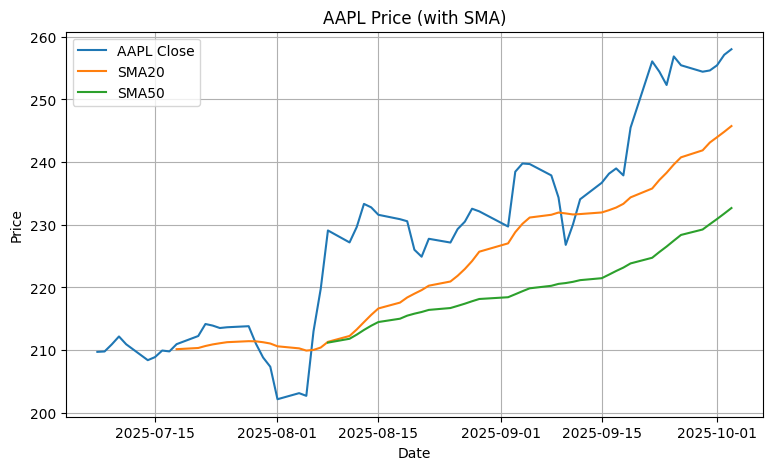

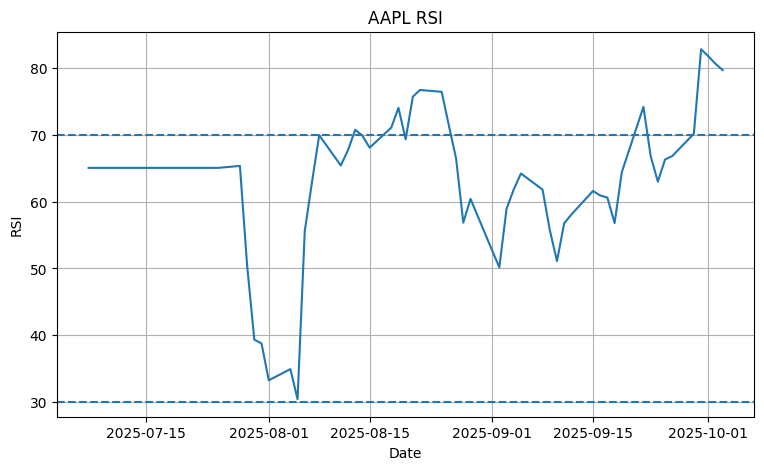

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


[2025-10-05 21:31:45] [CHAIN] News prompt-chaining for AAPL


INFO Successfully created table 'agno_sessions'

[2025-10-05 21:32:35] [NEWS] Here's a summary of recent news for AAPL:

*   **Apple Stock (AAPL) Gets Bullish Reviews from Evercore, Morgan Stanley on Services and iPhone 17 Strength** (TipRanks, 2025-10-03) - Positive: Analysts are bullish on AAPL due to services and iPhone 17 strength.
*   **Apple (AAPL) Stock Is Up, What You Need To Know** (Yahoo Finance, 2025-09-19) - Positive: AAPL stock jumped on strong early demand for its new iPhone 17 lineup.
*   **Jim Cramer Says Apple's (AAPL) A Wi...


Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


INFO Successfully created table 'agno_sessions'

[2025-10-05 21:32:52] [FIX] AAPL: refreshing 48h news
[2025-10-05 21:33:09] [FIX] AAPL: fetching next earnings date
[2025-10-05 21:33:09] [OVERVIEW] Metrics failed for AAPL: arg must be a list, tuple, 1-d array, or Series
[2025-10-05 21:33:09] [FIX] AAPL: recomputing valuation (multiples + DCF-lite)


Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


[2025-10-05 21:33:10] [FIX] AAPL: targeted fixes done=3 in 17.6s (budget left ~162.4s)


INFO Successfully created table 'agno_sessions'


AAPL — FINAL BRIEF (compact)

# AAPL — Research Brief
## Snapshot
- 3M Return: n/a
- Beta: n/a
- P/E: n/a
- EV/EBITDA: n/a
- Next Earnings: n/a
## News (Prompt-Chained: Ingest→Preprocess→Classify→Extract→Summarize)
Here's an analysis of the most impactful news for 'AAPL' from the last 48 hours:

*   **Apple Stock (AAPL) Gets Bullish Reviews from Evercore, Morgan Stanley on Services and iPhone 17 Strength** (TipRanks, 2025-10-03) - Positive: Analysts are bullish on AAPL due to services and iPhone 17 strength.
*   **NVDA and AAPL Supplier Foxconn Reports Record 3rd Quarter Earnings** (TipRanks, 2025-10-05) - Positive: AAPL supplier Foxconn reports record Q3 earnings, positive for supply chain.

## Catalysts & Risks
### Catalysts
*   **Services Growth**: Continued expansion and monetization of Apple's high-margin services segment.
*   **Product Innovation**: Strong demand and positive reception for future iPhone models (e.g., iPhone 17) and potential new product categories.
*   **Supply 

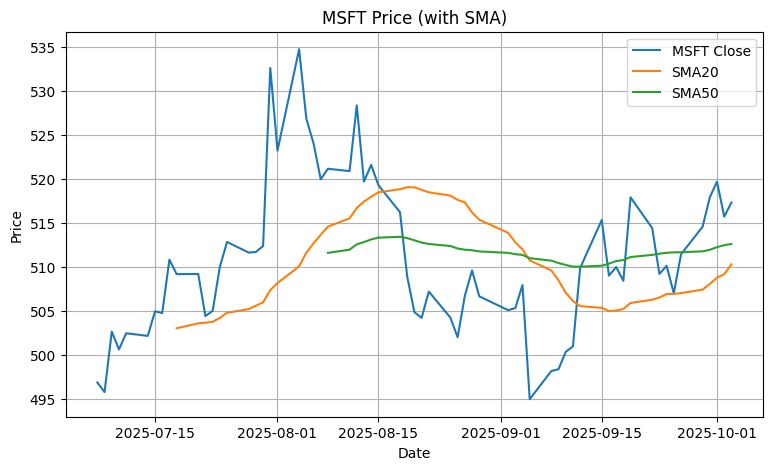

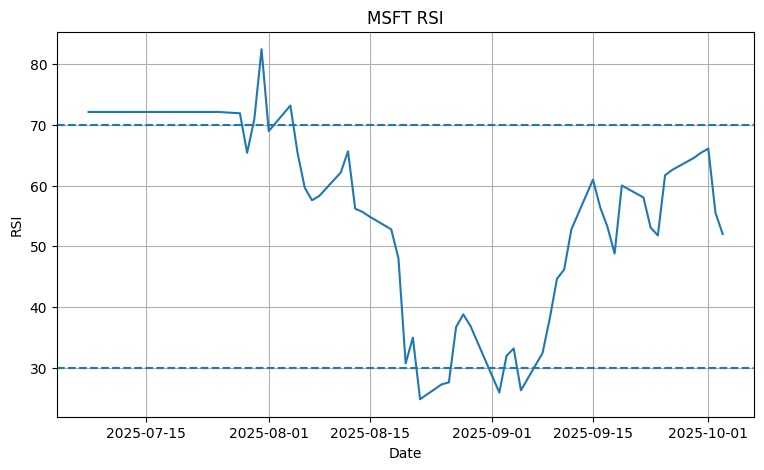

[2025-10-05 21:33:45] [CHAIN] News prompt-chaining for MSFT
[2025-10-05 21:34:51] [NEWS] Here's a summary of recent news for MSFT:

*   **Microsoft Corporation (MSFT) Unveils GPT-5 Agent Mode, Redefining Productivity with AI** (Insider Monkey, 2025-10-05) - Positive: Microsoft introduces GPT-5 Agent Mode in Word and Excel to boost productivity.
*   **Analysts Keep Raising Price Targets for Microsoft Stock - MSFT is Still Cheap** (Barchart, 2025-10-03) - Positive: Analysts are increasing price targets for MSFT, indicating it remains undervalued.
*   **...
[2025-10-05 21:35:08] [FIX] MSFT: fetching next earnings date
[2025-10-05 21:35:08] [OVERVIEW] Metrics failed for MSFT: arg must be a list, tuple, 1-d array, or Series
[2025-10-05 21:35:08] [FIX] MSFT: recomputing valuation (multiples + DCF-lite)
[2025-10-05 21:35:09] [FIX] MSFT: targeted fixes done=2 in 0.7s (budget left ~179.3s)

MSFT — FINAL BRIEF (compact)

# MSFT — Research Brief
## Snapshot
- 3M Return: n/a
- Beta: n/a
- P/E: n/a

,Ticker,3M Return,Beta,P/E,EV/EBITDA,Next ER,Target Δ,Confidence
0,AAPL,n/a,n/a,n/a,n/a,n/a,26.29%,n/a
1,MSFT,n/a,n/a,n/a,n/a,n/a,9.77%,n/a


In [16]:
INPUTS = ["AAPL", "MSFT"]
DATE_RANGE = DEFAULT_RANGE
DO_BACKTEST = True
DO_BASELINE = True

def run_for_ticker(symbol: str) -> Dict[str, Any]:
    t0 = time.time()
    log("RUN", f"=== {symbol} | Range: {DATE_RANGE} (+48h news) | Caps: total={ARTICLE_CAP}, per-source={PER_SOURCE_CAP} ===")

    dfp = fetch_prices(symbol, period=DATE_RANGE, interval="1d")
    overview = compute_overview_metrics(symbol, dfp)
    log("OVERVIEW", f"{symbol} metrics: " + json.dumps({k:overview[k] for k in overview}))

    plot_price_chart(symbol, dfp)

    news_txt = prompt_chain_news(symbol, DATE_RANGE)
    log("NEWS", news_txt)

    last_price = None
    try:
        if not dfp.empty:
            last_price = float(dfp["close"].astype(float).iat[-1])
    except Exception:
        pass
    mul = valuation_multiples(symbol, last_price=last_price)
    dcf = valuation_dcf_lite(symbol, last_price=last_price)

    evstudy = event_study(symbol, window=5) if DO_BACKTEST else {"rows": 0, "drifts": []}

    draft = brief_sections_to_text(symbol, overview, news_txt, mul, dcf, evstudy, eval_json={"scores":{}})

    eval_json = evaluate_brief(draft)
    pieces = {
        "overview": overview,
        "news_txt": news_txt,
        "mul": mul,
        "dcf": dcf,
        "evstudy": evstudy,
        "df_prices": dfp,
    }
    draft_final, eval_final = refine_once_if_needed(
        symbol,
        draft,
        eval_json,
        pieces,
        thresh=EVAL_THRESH,
        ticker_time_budget_left=TICKER_TIME_BUDGET
    )


    print("\n" + "="*80)
    print(f"{symbol} — FINAL BRIEF (compact)")
    print("="*80 + "\n")
    print(draft_final)

    used = time.time() - t0
    log("BUDGET", f"{symbol} completed in {used:.1f}s (budget {TICKER_TIME_BUDGET}s)")
    return {
        "symbol": symbol,
        "overview": overview,
        "mul": mul,
        "dcf": dcf,
        "evstudy": evstudy,
        "eval": eval_final,
        "draft": draft_final
    }

def run_all(inputs: List[str]):
    symbols = resolve_tickers(inputs, max_results=1)
    if not symbols:
        log("RUN", "No valid tickers to run.")
        return

    results = []
    rows = []
    for sym in symbols[:5]:
        res = run_for_ticker(sym)
        results.append(res)

        ov = res["overview"]
        mul = res["mul"]
        dcf = res["dcf"]
        target_delta = None
        if mul.get("implied_move") is not None:
            target_delta = mul["implied_move"]
        elif dcf.get("implied_move") is not None:
            target_delta = dcf["implied_move"]

        conf = None
        try:
            conf = res["eval"]["scores"]["overall"]
        except Exception:
            pass

        rows.append({
            "Ticker": sym,
            "3M Return": ov.get("return_3m"),
            "Beta": ov.get("beta"),
            "P/E": ov.get("pe"),
            "EV/EBITDA": ov.get("ev_ebitda"),
            "Next ER": ov.get("next_earnings"),
            "Target Δ": target_delta,
            "Confidence": conf
        })

    print("\n" + "="*80)
    print("MULTI-TICKER COMPARISON (compact)")
    print("="*80 + "\n")
    comp = build_comparison_table(rows)
    display(comp)

# ==== Execute ====
run_all(INPUTS)
